In [1]:
import sys
import time
import pickle
import numpy as np
import pandas as pd

from multiprocessing import Pool

from skimage import io
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras 
from keras.models import Sequential, Model, load_model
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from scripts.image import load_image

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Movie genre multi-class classifier
Trains convolution neural netowrk (based on inception V3 pre-trained network) to predict a movie genre based on the poster image. A movie can be assiciated with one genre.

In [2]:
img_rows, img_cols = 224, 224

In [3]:
# load images into memory
with open('data/tmdb_info.pickle', 'rb') as handle:
    tmdb_dict =  pickle.load(handle)
with Pool(6) as p:
    rs = p.map_async(load_image, list(tmdb_dict.keys()))
    p.close()
    while (True):
        if (rs.ready()): break
        remaining = rs._number_left
        print("Waiting for", remaining, "tasks to complete...")
        time.sleep(10)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 21 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 14 tasks to complete...
Waiting for 10 tasks to complete...
Waiting for 6 tasks to complete...
Waiting for 1 tasks to complete...


In [4]:
# one genre per movie
max_labels = 1

In [5]:
# extract labes for the loaded images
labels = []
features = []
for r in rs.get():
    if(r[1] is not None):
        movie_genres = tmdb_dict[r[0]].__dict__['genres']
        if(movie_genres is None or len(movie_genres) == 0):
            continue
        labels.append(' '.join([g['name']  for g in movie_genres[:max_labels]]))
        features.append(r[1])
features = np.asarray(features)
rs = None

In [6]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)
y = np_utils.to_categorical(y_encoded)
output_size = y.shape[1]

### Class weights  
Most frequent class will have weight 1.0, other classes will receive bigger weights reverse proportional to their relative frequencies.

In [7]:
class_freq = y.sum(axis = 0)
class_weight = {k: v for k, v in enumerate(class_freq.max()/class_freq)}
class_weight

{0: 3.431862745098039,
 1: 9.7168632893823741,
 2: 4.8332758025543665,
 3: 1.3453112990007687,
 4: 8.1312427409988377,
 5: 1.8617205158888446,
 6: 1.0,
 7: 10.022906227630637,
 8: 17.265104808877929,
 9: 52.441947565543074,
 10: 29.049792531120332,
 11: 4.5953396783721692,
 12: 4.4170347003154573,
 13: 20.651917404129794,
 14: 6.9316831683168321,
 15: 16.708830548926013,
 16: 22.26073131955485,
 17: 6.9557873820168901,
 18: 28.870103092783506,
 19: 15.269356597600872}

In [8]:
# put aside 10% of data for testing
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state = 540,  stratify = y)
print('Train label matrix shape:', y_train.shape)
print('Train predictor matrix shape:', X_train.shape)
print('Test label matrix shape:', y_test.shape)
print('Test predictor matrix shape:', X_test.shape)

Train label matrix shape: (52942, 20)
Train predictor matrix shape: (52942, 224, 224, 3)
Test label matrix shape: (5883, 20)
Test predictor matrix shape: (5883, 224, 224, 3)


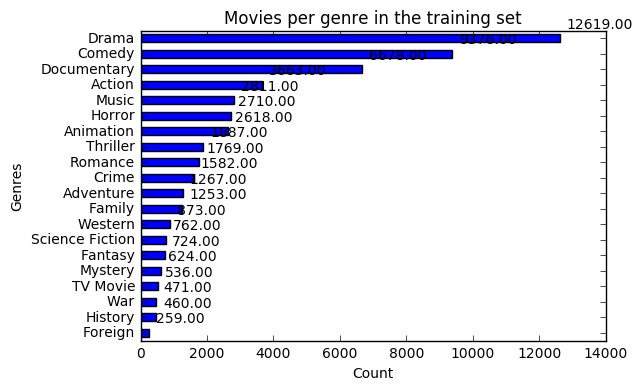

In [9]:
label_df = pd.DataFrame(y_train)
label_df.columns = encoder.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the training set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

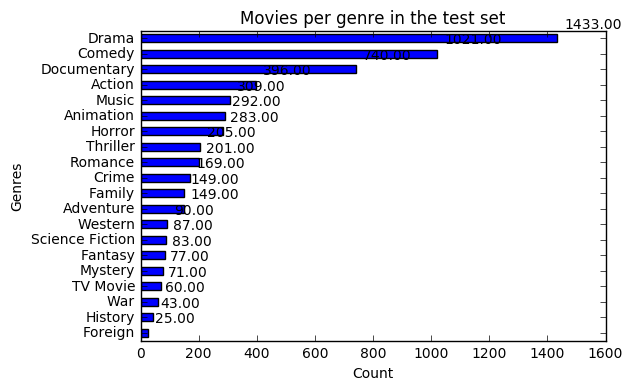

In [10]:
label_df = pd.DataFrame(y_test)
label_df.columns = encoder.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the test set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

In [11]:
# create model absed on inception V3 CNN
def create_v3():
    input_shape = (224, 224, 3)

    base_model = InceptionV3(
        input_shape = input_shape, 
        weights='imagenet', 
        include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(output_size, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    return model

In [12]:
model = create_v3()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 111, 111, 32)  96                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

In [13]:
earlyStopping = EarlyStopping(
    monitor='val_acc', patience = 5, min_delta = 0.01, verbose = 0, mode = 'max')

In [14]:
# train the output layer
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(
    X_train, 
    y_train, 
    class_weight = class_weight,
    batch_size = 256, 
    epochs = 10, 
    verbose = 1,
    validation_split = 0.2, # 20% reserved for held-out validation data
    callbacks = [earlyStopping]
)

Train on 42353 samples, validate on 10589 samples
Epoch 1/10
42353/42353 [==============================] - 459s - loss: 15.4053 - acc: 0.0815 - val_loss: 14.7508 - val_acc: 0.0699
Epoch 2/10
42353/42353 [==============================] - 441s - loss: 12.8421 - acc: 0.1362 - val_loss: 12.8260 - val_acc: 0.1523
Epoch 3/10
42353/42353 [==============================] - 443s - loss: 12.0123 - acc: 0.1615 - val_loss: 13.2148 - val_acc: 0.1314
Epoch 4/10
42353/42353 [==============================] - 442s - loss: 11.2681 - acc: 0.1854 - val_loss: 12.6481 - val_acc: 0.2139
Epoch 5/10
42353/42353 [==============================] - 445s - loss: 10.4226 - acc: 0.2106 - val_loss: 12.0825 - val_acc: 0.1792
Epoch 6/10
42353/42353 [==============================] - 443s - loss: 9.5028 - acc: 0.2402 - val_loss: 12.5856 - val_acc: 0.1938
Epoch 7/10
42353/42353 [==============================] - 440s - loss: 8.6456 - acc: 0.2749 - val_loss: 13.0680 - val_acc: 0.1219
Epoch 8/10
42353/42353 [===========

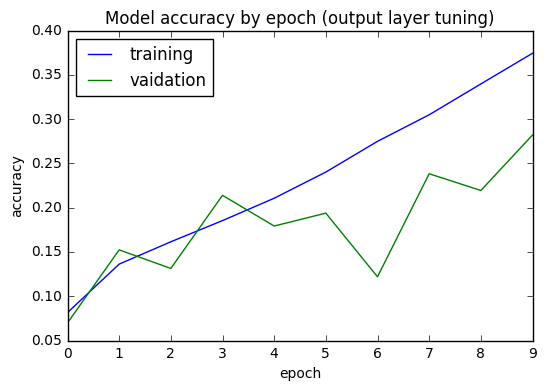

In [16]:
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.title('Model accuracy by epoch (output layer tuning)')

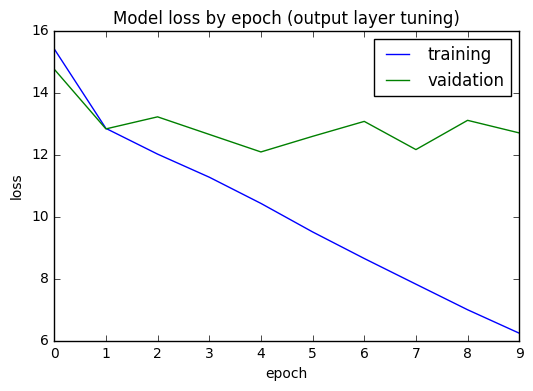

In [17]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title('Model loss by epoch (output layer tuning)')

In [18]:
model.save('models/cnn_v3_1.h5')

In [19]:
# fine tune the top 2 inception blocks
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

In [ ]:
model.compile(
    optimizer=SGD(lr = 0.0001, momentum=0.9), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, 
    y_train, 
    class_weight = class_weight,
    batch_size = 256,
    epochs = 30, 
    verbose = 1,
    validation_split = 0.2, # 20% reserved for held-out validation data,
    callbacks = [earlyStopping]
)

Train on 42353 samples, validate on 10589 samples
Epoch 1/30
42353/42353 [==============================] - 620s - loss: 4.5480 - acc: 0.4859 - val_loss: 10.5725 - val_acc: 0.3660
Epoch 2/30
42353/42353 [==============================] - 607s - loss: 3.1731 - acc: 0.5738 - val_loss: 10.6909 - val_acc: 0.4128
Epoch 3/30
42353/42353 [==============================] - 609s - loss: 2.5897 - acc: 0.6279 - val_loss: 10.8402 - val_acc: 0.4434
Epoch 4/30
42353/42353 [==============================] - 608s - loss: 2.1960 - acc: 0.6719 - val_loss: 11.0602 - val_acc: 0.4681
Epoch 5/30
42353/42353 [==============================] - 610s - loss: 1.8978 - acc: 0.7076 - val_loss: 11.1863 - val_acc: 0.4908
Epoch 6/30
42353/42353 [==============================] - 608s - loss: 1.6631 - acc: 0.7387 - val_loss: 11.3960 - val_acc: 0.5069
Epoch 7/30
42353/42353 [==============================] - 610s - loss: 1.4768 - acc: 0.7660 - val_loss: 11.5230 - val_acc: 0.5231
Epoch 8/30
42353/42353 [================

In [ ]:
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.title('Model accuracy by epoch (top 2 inception blocks tuning)')

In [ ]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='vaidation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title('Model loss by epoch (top 2 inception blocks tuning)')

In [ ]:
model.save('models/cnn_v3_1.h5')

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred_test = np.zeros(y_pred_proba.shape)
y_pred_test[y_pred_proba > 0.5] = 1

In [ ]:
print(classification_report(y_test, y_pred_test, target_names = encoder.classes_))

In [ ]:
# save test data so we can evaluate performance again
with open('models/cnn_v3_1_test.pickle', 'wb') as handle:
    pickle.dump((X_test, y_test), handle, protocol = pickle.HIGHEST_PROTOCOL)